In [1]:
# LIBRERIAS
import matplotlib
from ipywidgets import interact,widgets
import numpy as np
import matplotlib.pylab as plt
import celluloid as cell  #animations
import pandas as pd
import os
from scipy.interpolate import CubicSpline
import math

#sns.set_theme()
#matplotlib.rc('xtick', labels
# ize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

path=os.getcwd()



def fourierT(f):

    return (np.fft.fftshift(np.fft.fft(np.fft.fftshift(f))))


def fourierI(f):

    return (np.fft.fftshift(np.fft.ifft(np.fft.fftshift(f))))



# Parametros relavantes de la simulación laboratorio.

In [3]:
frep=37.5*1e6
tau1=150e-15 ; tau2=200e-15 # Rango ancho temporal pulso.
WaveLength=1550e-9      #reference wavelength [m]
c = 299792458
w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
length = 2.0             #ibre length [m]
D=-1.0*1e-12*1e9*1e-3 #Dispersion
dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
#betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
beta2=-WaveLength**2/(2*np.pi*c)*D
P0=130e-3 # Potencia media.
Ppeak=P0/(frep*tau1)
Ld=tau1**2/beta2
Lnl=1/(Ppeak*10.8*1e-3)
gamma=10.8*1e-3

# # Espectro Paper.

In [4]:
c = 299792458;            #speed of light [m/s]
#Constants
n = 2**11    # number of grid points
TimeWindow = 30*1e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-TimeWindow,TimeWindow,dT) #  time grid
#Laser parameters
WaveLength=1550e-9      #reference wavelength [m]
w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
nu= 100e6 #Repetition rate (Hz)
t0 = 80e-15       # duration of input [s]
power = 0.625e-3        #peak power of input [W]
A = np.sqrt(power)*np.exp(-TimeGrid**2/(2*t0**2))   #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
V = np.arange(-n,n,1)*np.pi/(n*dT)
#Fiber parameters 
length = 10*100             #ibre length [m]
# D=-1.0*1e-12*1e9*1e-3 #Dispersion
# dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
#betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
beta2 = 0.5*(1e-24)*1e-3
beta3= 0.07*(1e-36)*1e-3#(WaveLength**2/(2*np.pi*c))**2*(2*D/WaveLength+dD)
gamma = 0.1  #nonlinear coefficient [1/W/m]
loss = 0       #loss [dB/m]
T = 3e-15
S  = 1/w0

In [5]:
def fourier_split(A1,V,S,T,gamma,beta2,beta3,lenght):

    c = 299792458
   
    h = 10

    UD1 = np.exp(-h*0.5*(1j*V**2*0.5*beta2-1j*beta3/6*V**3),dtype=complex)

    zz = 0

    while zz<=lenght:

        A1a = fourierI(UD1*fourierT(A1))

        N1 = 1j*gamma*(np.abs(A1a)**2
                       +1j*S*np.conjugate(A1a)*fourierI(1j*V*fourierT(A1a))
                       +(1j*S-T)*fourierI(1j*V*fourierT(np.abs(A1a)**2)))*A1a

        A1aa = A1a+(h*N1)
     
        A1 = fourierI(UD1*fourierT(A1aa))

        zz+=h
        
    return A1

In [6]:
W = V + w0
WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
N1 = 1300e-9 ;N2=1800e-9
iis = np.array([(i>N1 and i<N2) for i in WL])




In [7]:
y = fourier_split(A,V,S,T,gamma,beta2,beta3,length)

(-5.0, 20.0)

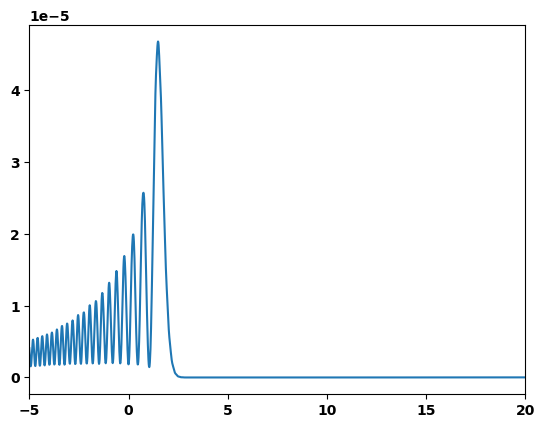

In [67]:
plt.plot(TimeGrid*1e12,np.abs(y)**2,label='in')
plt.xlim(-5,20)


In [8]:
def new_method(I,phi,gamma,S,T,dt,h):
    '''
    Este codigo calcula un paso espacial. Recibe un array
    con la intensidad y la fase. Modifica ese array para dar lugar al
    siguiente paso espacial.

    '''

   
    In_j = I  # Recibe In_j
    phin_j = phi  # Recibe phin_j

    Inew = []
    phinew = []

    # Ciclo para calcular cada componente del array que contendra el siguiente
    # paso espacial
    for j in range(len(I)):

        Itn_j = (In_j[j]+In_j[j-1])*0.5
        deltaIn_j = In_j[j]-In_j[j-1]
        deltatheta = phin_j[j]-phin_j[j-1]
        deltataun_j = min([abs(deltatheta),abs(deltatheta+2*np.pi),abs(deltatheta-2*np.pi)])


        if abs(deltatheta) == deltataun_j:
            deltaphin_j = deltatheta

        elif  abs(deltatheta+2*np.pi) == deltataun_j:
            deltaphin_j = deltatheta + 2*np.pi
        else:  
            deltaphin_j = deltatheta - 2*np.pi


        In1_j = In_j[j]-h/dt*(3*gamma*S*Itn_j*deltaIn_j)
        phitn1_j = phin_j[j]-h/dt*(gamma*T*deltaIn_j
                                +gamma*S*Itn_j*deltaphin_j
                                )
        phin1_j = phitn1_j + h*gamma*In1_j

        Inew.append(In1_j) # Intensidad en el siguiente paso espacial
        phinew.append(phin1_j) #vfase en el siguiente paso espacial

    return np.sqrt(np.array(Inew))*np.exp(1j*np.array(phinew))

def fourier_split_mod(A1,V,S,T,gamma,betas,lenght,dT,steps):

    
    h = lenght/steps
    
    betas_freq = sum((1j)**(i+1)*betas[i]*(1j*V)**(i+2)/math.factorial(i+2) for i in range(0,len(betas)))
    
    UD1 = np.exp(-h*0.5*betas_freq,dtype=complex)

    for i in range(steps):


        A1a = fourierI(UD1*fourierT(A1))

        N1 = new_method(np.abs(A1a)**2,np.angle(A1a),gamma,S,T,dT,h)

        A1aa = N1
     
        A1 = fourierI(UD1*fourierT(A1aa))
       
    return A1


In [9]:
def evol_espectrum(A1,V,S,T,gamma,betas,lenght,dT,steps):

    espec = np.zeros((steps,len(A1)))
    
    h = lenght/steps
    
    betas_freq = sum((1j)**(i+1)*betas[i]*(-1j*V)**(i+2)/math.factorial(i+2) for i in range(0,len(betas)))
    UD1 = np.exp(h*0.5*betas_freq,dtype=complex)


    for i in range(steps): 

    
        espec[i,:] = np.abs(A1)**2
        
        A1a = fourierI(UD1*fourierT(A1))

        N1 = new_method(np.abs(A1a)**2,np.angle(A1a),gamma,S,T,dT,h)

        A1aa = N1
     
        A1 = fourierI(UD1*fourierT(A1aa))
        
    return espec


In [10]:
c = 299792458;            #speed of light [m/s]
#Constants
n = 2**12    # number of grid points
TimeWindow = 30*1e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-TimeWindow,TimeWindow,dT) #  time grid
#Laser parameters
WaveLength=1550e-9      #reference wavelength [m]
w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
nu= 100e6 #Repetition rate (Hz)
t0 = 80e-15       # duration of input [s]
power = 0.625e-3        #peak power of input [W]
A = np.sqrt(power)*np.exp(-TimeGrid**2/(2*t0**2))   #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
V = np.arange(-n,n,1)*np.pi/(n*dT)
#Fiber parameters 
length = 1000            #ibre length [m]
steps = 200
# D=-1.0*1e-12*1e9*1e-3 #Dispersion
# dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
#betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
beta2 = 0.5*1e-24*1e-3
beta3= 0.07*1e-36*1e-3#(WaveLength**2/(2*np.pi*c))**2*(2*D/WaveLength+dD)
betas = [beta2,beta3]
gamma = 0.1  #nonlinear coefficient [1/W/m]
loss = 0       #loss [dB/m]
T = 3e-15
S  = 1/w0

(-5.0, 20.0)

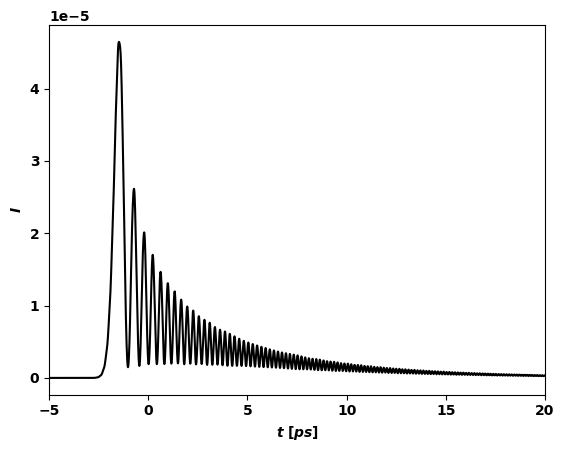

In [11]:
plt.plot(TimeGrid*1e12,np.abs(fourier_split_mod(A,V,S,T,gamma,betas,length,dT,steps))**2,'k')
plt.xlabel('$t$ $[ps]$')
plt.ylabel('$I$')
plt.xlim(-5,20)

# Uso de nuevo método para algunas pruebas

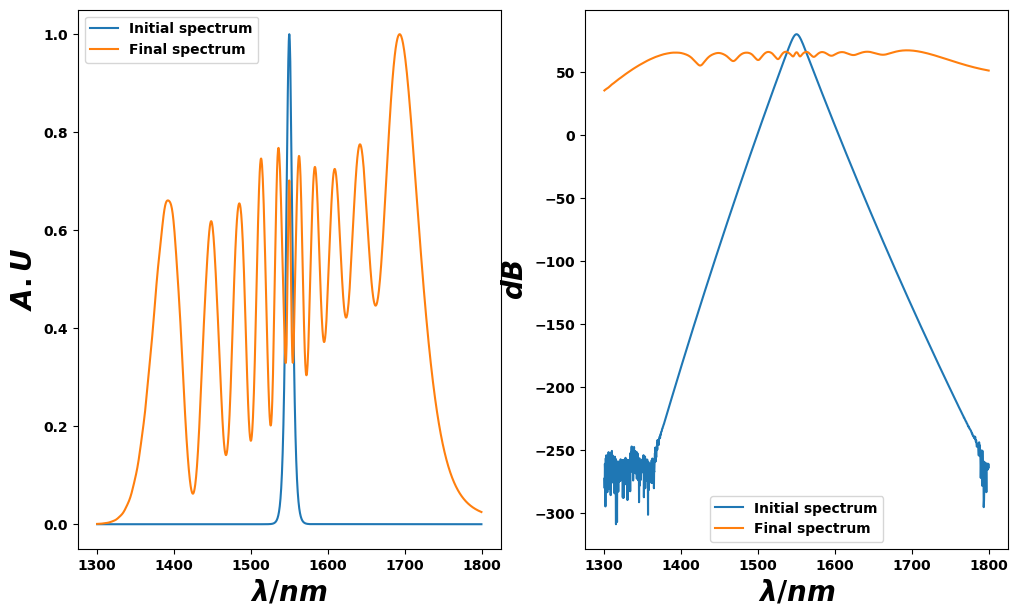

In [60]:
n = 2**13    # number of grid points
TimeWindow = 12.5e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-n/2,n/2,1)*dT #  time grid
WaveLength=1550e-9      #reference wavelength [m]
c = 299792458
w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
nu=100e6 #Repetition rate (Hz)
t0 =200e-15       # duration of input [s]
power = 80e-3/(nu*t0)        #peak power of input [W]
length = 1.0             #ibre length [m]
D=-1.0*1e-12*1e9*1e-3 #Dispersion
dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
#betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
beta2=-WaveLength**2/(2*np.pi*c)*D
beta3=(WaveLength**2/(2*np.pi*c))**2*(2*D/WaveLength+dD)
betas = [beta2,beta3]
A = np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
gamma = 10.8e-3
dw=np.pi/(n*dT)
V=np.array([j*dw for j in range(-int(n/2),int(n/2))])
steps = 500
S = 0
T = 0.5e-15
sol=fourier_split_mod(A,V,S,T,gamma,betas,length,dT,steps)
#plt.plot(TimeGrid,A)
f=plt.figure(figsize=(12,7))


plt.subplot(121)


dw=np.pi/(n*dT)
V=np.array([j*dw for j in range(-int(n/2),int(n/2))])
W=V+w0
WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
N1=1300e-9 ;N2=1800e-9
iis=np.array([(i>N1 and i<N2) for i in WL])
ff=fourierT(sol)
fi=fourierT(A)
plt.plot(WL[iis]*1e9,np.abs(fi[iis])**2/max(np.abs(fi[iis])**2),label='Initial spectrum')
plt.plot(WL[iis]*1e9,np.abs(ff[iis])**2/max(np.abs(ff[iis])**2),label='Final spectrum')
plt.xlabel('$\lambda/nm$',fontsize=20)
plt.ylabel('$A.U$',fontsize=20)
plt.legend()
#print('Ld=',t0**2/abs(beta2))
#print('Lnl=',1/(gamma*power))

plt.subplot(122)

plt.plot(WL[iis]*1e9,10*np.log10(np.abs(fi[iis])**2),label='Initial spectrum')
plt.plot(WL[iis]*1e9,10*np.log10(np.abs(ff[iis])**2),label='Final spectrum')
plt.xlabel('$\lambda/nm$',fontsize=20)
plt.ylabel('$dB$',fontsize=20)
plt.legend()

In [22]:
fourier_split_mod(A,V,S,T,gamma,betas,length,dT,steps)

array([-2.67984746e-10+1.14184218e-11j,  2.67981193e-10-1.14352972e-11j,
       -2.67913691e-10+1.14632748e-11j, ...,
        2.67895928e-10-1.09940945e-11j, -2.68173039e-10+1.10366161e-11j,
        2.68094880e-10-1.11268772e-11j])

In [51]:
# Datos del espectro de thorlabs
df = pd.read_csv(os.path.dirname(os.getcwd())+'\\Nonlinear_Optics/Epectro_HN1550_80mW_dhms.csv')
Power=np.array(df['Spectrum HN1550_80mW (normalized)'][:]) #Power
Wave=np.array(df['Wavelenght (nm)'][:]) #Power
Wave_new=np.linspace(min(Wave),max(Wave),800)
cs = CubicSpline(Wave, Power)
Power_new=cs(Wave_new)

In [62]:
def anim2(T):
    f = plt.figure(figsize=(10, 5),dpi=200)
    # plot resultados
    #jojasfjas
    n = 2**13    # number of grid points
    TimeWindow = 12.5e-12 # width of time window [s]     
    dT = TimeWindow/n
    TimeGrid =  np.arange(-n/2,n/2,1)*dT #  time grid
    WaveLength=1550e-9      #reference wavelength [m]
    c = 299792458
    w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
    nu=100e6 #Repetition rate (Hz)
    t0 =200e-15       # duration of input [s]
    power = 80e-3/(nu*t0)        #peak power of input [W]
    length = 1.0             #ibre length [m]
    D=-1.0*1e-12*1e9*1.3e-3 #Dispersion
    dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
    #betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
    beta2=-WaveLength**2/(2*np.pi*c)*D
    beta3=(WaveLength**2/(2*np.pi*c))**2*(2*D/WaveLength+dD)
    betas = [beta2,beta3]
    A = np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
    dw=np.pi/(n*dT)
    V=np.array([j*dw for j in range(-int(n/2),int(n/2))])
    W=V+w0
    WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
    N1=1300e-9 ;N2=1800e-9
    S = 1/w0
    steps = 100
    sol=fourier_split_mod(A,V,S,T*1e-15,gamma,betas,length,dT,steps)
    iis=np.array([(i>N1 and i<N2) for i in WL])
    ff=fourierT(sol)
    fi=fourierT(A)
    plt.plot(WL[iis]*1e9,np.abs(fi[iis])**2/max(np.abs(fi[iis])**2),label='Initial spectrum')
    plt.plot(WL[iis]*1e9,np.abs(ff[iis])**2/max(np.abs(ff[iis])**2),'--k',label='Final spectrum')
    plt.plot(Wave,Power,'--r',label='Final spectrum Thorlabs')
    plt.xlabel('$\lambda$ $[nm]$')
    plt.xlim(1400,1750)
    #plt.title(str(round(z[-1],3))+' [m]')
    plt.ylabel('Normalized Intensity (u.a)' )
    plt.legend(loc ='upper right')

    
    

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        T= widgets.FloatSlider(min=0,max=10,value=0.49,step=0.01,**opc)
        #mm
        );

interactive(children=(FloatSlider(value=0.49, continuous_update=False, description='T', max=10.0, readout_form…

# Dudley

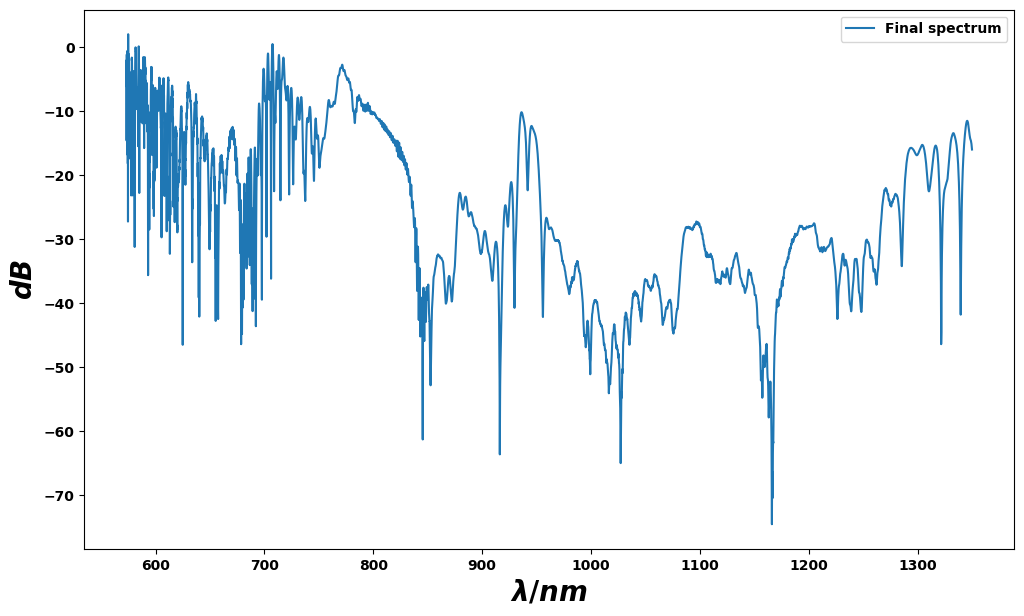

In [70]:
n = 2**13    # number of grid points
TimeWindow = 12.5e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-n/2,n/2,1)*dT #  time grid
WaveLength=835e-9      #reference wavelength [m]
c = 299792458
w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
t0 = 28.4e-15       # duration of input [s]
power = 10000      #peak power of input [W]
length =  15e-2           #ibre length [m]
#betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
betas = [-1.1830e-26, 8.1038e-41, -9.5205e-56,  2.0737e-70, 
         -5.3943e-85,  1.3486e-99, -2.5495e-114,  3.0524e-129, 
         -1.7140e-144]
A = np.sqrt(power)*1/np.cosh(TimeGrid/t0) # input field [W^(1/2)]
gamma = 0.11
dw=np.pi/(n*dT)
V=np.array([j*dw for j in range(-int(n/2),int(n/2))])
steps = 200
S = 1/w0
T = 2.5e-15
sol = fourier_split_mod(A,V,S,T,gamma,betas,length,dT,steps)
#plt.plot(TimeGrid,A)
f=plt.figure(figsize=(12,7))


# plt.subplot(121)
dw=np.pi/(n*dT)
V=np.array([j*dw for j in range(-int(n/2),int(n/2))])
W=V+w0
WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
N1=400e-9 ;N2=1350e-9
iis=np.array([(i>N1 and i<N2) for i in WL])
ff=fourierT(sol)/np.amax(fourierT(sol))
# plt.plot(WL[iis]*1e9,np.abs(fi[iis])**2/max(np.abs(fi[iis])**2),label='Initial spectrum')
# plt.plot(WL[iis]*1e9,np.abs(ff[iis])**2/max(np.abs(ff[iis])**2),label='Final spectrum')
# plt.xlabel('$\lambda/nm$',fontsize=20)
# plt.ylabel('$A.U$',fontsize=20)
# plt.legend()
# #print('Ld=',t0**2/abs(beta2))
# #print('Lnl=',1/(gamma*power))

# plt.subplot(122)
y = 10*np.log10(np.abs(ff[iis])**2)
#plt.plot(WL[iis]*1e9,10*np.log10(np.abs(fi[iis])**2),label='Initial spectrum')
plt.plot(WL[iis]*1e9,y,label='Final spectrum')
plt.xlabel('$\lambda/nm$',fontsize=20)
plt.ylabel('$dB$',fontsize=20)
plt.legend()

In [81]:
TimeGrid

array([-6.25000000e-12, -6.24847412e-12, -6.24694824e-12, ...,
        6.24542236e-12,  6.24694824e-12,  6.24847412e-12])

In [82]:
N1=-1e-12 ;N2=6e-12
iis=np.array([(i>N1 and i<N2) for i in TimeGrid])

In [83]:
y = evol_espectrum(A,V,S,T,gamma,betas,length,dT,steps)[:,iis]

In [87]:
y[ y<-1e-40] = 0

C:\Users\esteb\AppData\Local\Temp\ipykernel_26320\524309566.py:16: RuntimeWarning: divide by zero encountered in log10
  cs1=ax1.contour(X, Y,  10*np.log10(np.abs(y)**2))


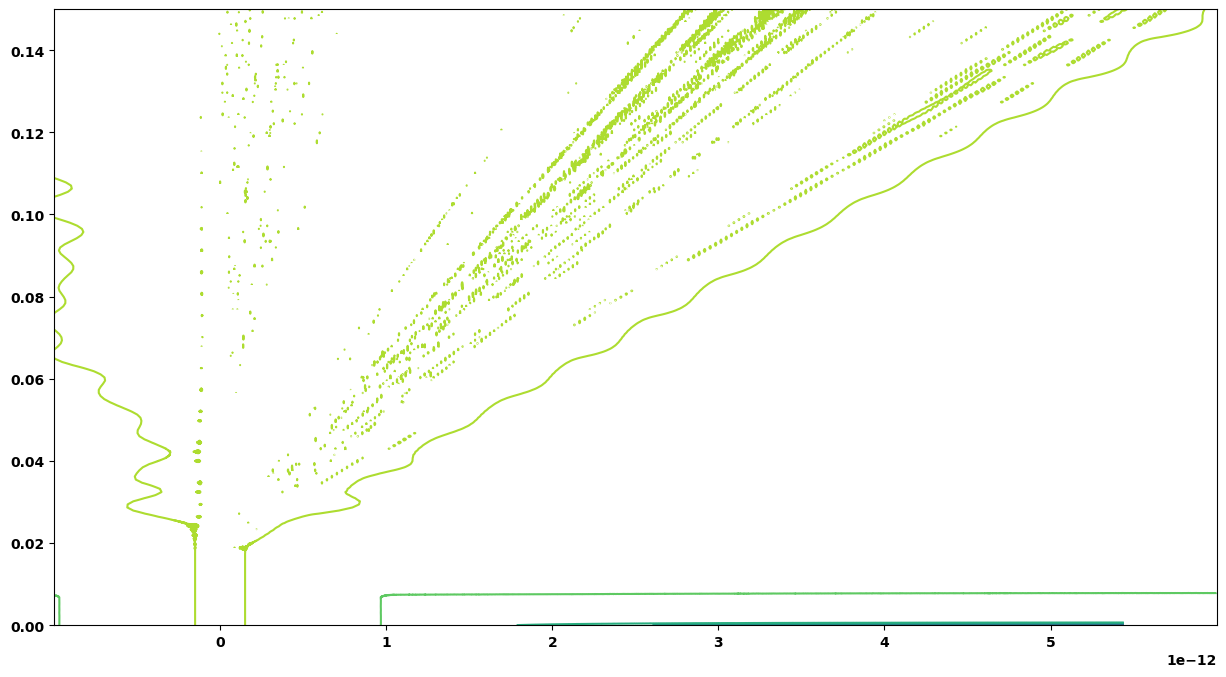

In [99]:
fig1, axs = plt.subplots(nrows=1,ncols=1, figsize=(15,8),sharex='col', sharey='row')
(ax1) = axs

X = TimeGrid[iis]
Y = np.linspace(0,length,steps)
X,Y = np.meshgrid(X,Y)

plt.rcParams['figure.figsize'] = 24, 12 # para modificar el tamaño de la figura
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

font = {'weight' : 'bold',
        'size'   : 15}


cs1=ax1.contour(X, Y,  10*np.log10(np.abs(y)**2))


# FOURIER SPLIT METHOD.

In [37]:
def fourier_split(psi0,gamma,beta2,beta3,deltat,lenght):

    N=len(psi0) 

    dz=0.001

    dw=np.pi/(N*deltat)

    V=np.array([j*dw for j in range(-int(N/2),int(N/2))])

    psi = psi0

    UD=np.exp(dz*0.5*(1j*V**2*0.5*beta2-1j*beta3/6*V**3),dtype=complex)

    zz=0

    while zz<=lenght:

        step1=fourierI(UD*fourierT(psi))

        # N= dz*1j*gamma*(np.abs(psi)**2#+1j*S*np.conjugate(psi)*fourierI(1j*V*fourierT(psi))
        #                +(1j*S-T)*fourierI(1j*V*fourierT(abs(psi)**2)))

        N= dz*1j*gamma*(np.abs(psi)**2)
        UN=np.exp(N,dtype=complex)

        step2=UN*step1

        step3=fourierI(UD*fourierT(step2))

        psi = step3

        zz+=dz
        
    return psi





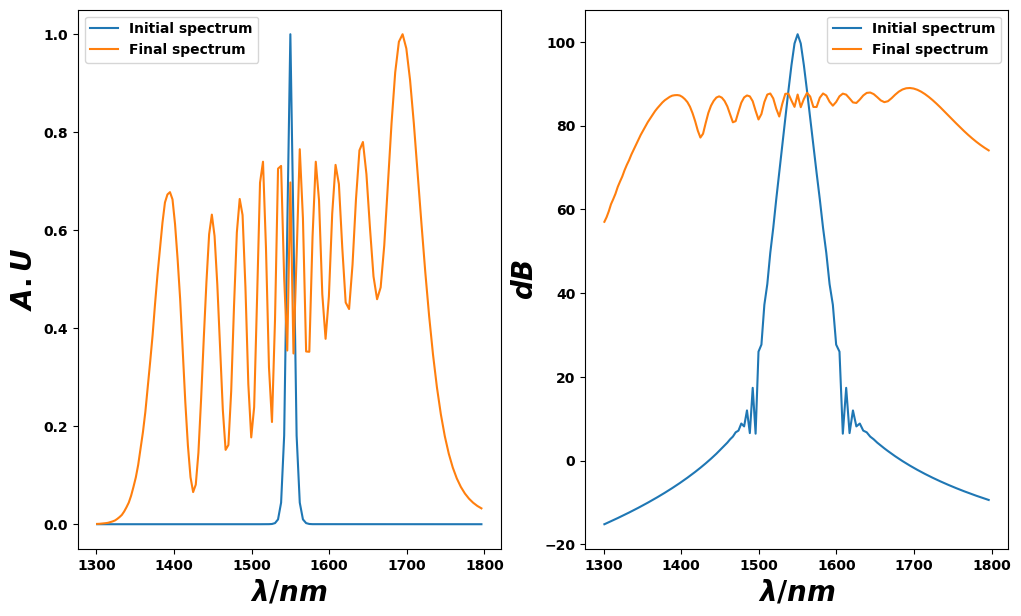

In [38]:
n = 2**13    # number of grid points
TimeWindow = 1e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-n/2,n/2,1)*dT #  time grid
WaveLength=1550e-9      #reference wavelength [m]
c = 299792458
w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
nu=100e6 #Repetition rate (Hz)
t0 =200e-15       # duration of input [s]
power = 80e-3/(nu*t0)        #peak power of input [W]
length = 1.0             #ibre length [m]
D=-1.0*1e-12*1e9*1e-3 #Dispersion
dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
#betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
beta2=-WaveLength**2/(2*np.pi*c)*D
beta3=(WaveLength**2/(2*np.pi*c))**2*(2*D/WaveLength+dD)
A = np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
gamma = 10.8e-3
sol=fourier_split(A,gamma,beta2,beta3,dT,length)
#plt.plot(TimeGrid,A)
f=plt.figure(figsize=(12,7))


plt.subplot(121)


dw=np.pi/(n*dT)
V=np.array([j*dw for j in range(-int(n/2),int(n/2))])
W=V+w0
WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
N1=1300e-9 ;N2=1800e-9
iis=np.array([(i>N1 and i<N2) for i in WL])
ff=fourierT(sol)
fi=fourierT(A)
plt.plot(WL[iis]*1e9,np.abs(fi[iis])**2/max(np.abs(fi[iis])**2),label='Initial spectrum')
plt.plot(WL[iis]*1e9,np.abs(ff[iis])**2/max(np.abs(ff[iis])**2),label='Final spectrum')
plt.xlabel('$\lambda/nm$',fontsize=20)
plt.ylabel('$A.U$',fontsize=20)
plt.legend()
#print('Ld=',t0**2/abs(beta2))
#print('Lnl=',1/(gamma*power))

plt.subplot(122)

plt.plot(WL[iis]*1e9,10*np.log10(np.abs(fi[iis])**2),label='Initial spectrum')
plt.plot(WL[iis]*1e9,10*np.log10(np.abs(ff[iis])**2),label='Final spectrum')
plt.xlabel('$\lambda/nm$',fontsize=20)
plt.ylabel('$dB$',fontsize=20)
plt.legend()

# Coupled equations.

In [3]:
def new_methodc(I1,I2,phi1,phi2,gamma,S,C,B,T,dt,h,cond=1):
    '''
    Este codigo calcula un paso espacial. Recibe un array
    con la intensidad y la fase. Modifica ese array para dar lugar al
    siguiente paso espacial.

    '''

    I1n_j = I1  # Recibe In_j
    phi1n_j = phi1  # Recibe phin_j
    I2n_j = I2  # Recibe In_j
    phi2n_j = phi2  # Recibe phin_j

    I1new = []
    phi1new = []
    I2new = []
    phi2new = []

    # Ciclo para calcular cada componente del array que contendra el siguiente
    # paso espacial
    for j in range(0,len(I1n_j)):

        I1tn_j = (I1n_j[j]+I1n_j[j-1])*0.5
        deltaI1n_j = I1n_j[j]-I1n_j[j-1]
        deltatheta1 = phi1n_j[j]-phi1n_j[j-1]
        deltatau1n_j = min([abs(deltatheta1),abs(deltatheta1+2*np.pi),abs(deltatheta1-2*np.pi)])

        I2tn_j = (I2n_j[j]+I2n_j[j-1])*0.5
        deltaI2n_j = I2n_j[j]-I2n_j[j-1]
        deltatheta2 = phi2n_j[j]-phi2n_j[j-1]
        deltatau2n_j = min([abs(deltatheta2),abs(deltatheta2+2*np.pi),abs(deltatheta2-2*np.pi)])

 
        if cond==1:
           


            if abs(deltatheta1) == deltatau1n_j:
                deltaphi1n_j = deltatheta1
            elif  abs(deltatheta1+2*np.pi) == deltatau1n_j:
                deltaphi1n_j = deltatheta1 + 2*np.pi
            else:
                deltaphi1n_j = deltatheta1 - 2*np.pi
                
            I1n1_j = I1n_j[j]-h/dt*gamma*S*((3*I1tn_j+B*I2tn_j)*deltaI1n_j
                                            +2*B*I1tn_j*deltaI2n_j)
            
            phi1tn1_j = phi1n_j[j]-h/dt*gamma*(T*(deltaI1n_j+B*deltaI2n_j)
                                    +S*(I1tn_j+B*I2tn_j)*deltaphi1n_j)
        
            phi1n1_j = phi1tn1_j + h*gamma*(I1n1_j+C*I2n_j[j])

            I1new.append(I1n1_j) # Intensidad en el siguiente paso espacial
            phi1new.append(phi1n1_j) #vfase en el siguiente paso espacial

        else:
            if abs(deltatheta2) == deltatau2n_j:
                deltaphi2n_j = deltatheta2
            elif  abs(deltatheta2+2*np.pi) == deltatau2n_j:
                deltaphi2n_j = deltatheta2 + 2*np.pi
            else:
                deltaphi2n_j = deltatheta2 - 2*np.pi
                

            I2n1_j = I2n_j[j]-h/dt*gamma*S*((3*I2tn_j+B*I1tn_j)*deltaI2n_j
                                            +2*B*I2tn_j*deltaI1n_j)
            phi2tn1_j = phi2n_j[j]-h/dt*gamma*(T*(deltaI2n_j+B*deltaI1n_j)
                                    +S*(I2tn_j+B*I1tn_j)*deltaphi2n_j
                                    )
            phi2n1_j = phi2tn1_j + h*gamma*(I2n1_j+C*I1n_j[j])

       
            I2new.append(I2n1_j) # Intensidad en el siguiente paso espacial
            phi2new.append(phi2n1_j) #vfase en el siguiente paso espacial

      
        # I2n_j = I2n1_j
        # phi2n_j = phi2n1_j
    if cond == 1:
        return np.sqrt(np.array(I1new))*np.exp(1j*np.array(phi1new))
    else:

        return np.sqrt(np.array(I2new))*np.exp(1j*np.array(phi2new))
    


def fourier_split_modc(A1,A2,V,delta,S,T,C,B,gammas,betas1,betas2,lenght,dt,steps):

    
    h = lenght/steps
  
    betas_freq1 = sum((1j)**(i+1)*betas1[i]*(1j*V)**(i+2)/math.factorial(i+2) for i in range(0,len(betas1)))
    betas_freq2 = sum((1j)**(i+1)*betas2[i]*(1j*V)**(i+2)/math.factorial(i+2) for i in range(0,len(betas2)))
    
    UD1 = np.exp(-h*0.5*betas_freq1,dtype=complex)
    UD2 = np.exp(-h*0.5*(betas_freq2+1j*delta*V),dtype=complex)



    for i in range(steps):
        
        stability1 = (h/dt*gammas[0]*S[0]*np.amax(3*np.abs(A1)**2+B[0]*np.abs(A2)**2))
        stability2 = (h/dt*gammas[1]*S[1]*np.amax(3*np.abs(A1)**2+B[1]*np.abs(A2)**2))

        if stability1 < 1 and stability2 < 2:
            print(True)

        A1a = fourierI(UD1*fourierT(A1))
        A2a = fourierI(UD2*fourierT(A2))
        I1 = np.abs(A1a)**2
        phi1 = np.angle(A1a)
        I2 = np.abs(A2a)**2
        phi2 = np.angle(A2a)
        

        A1as = new_methodc(I1,I2,phi1,phi2,gammas[0],S[0],C[0],B[0],T,dt,h/2)

        I1as = np.abs(A1as)**2
        phi1as = np.angle(A1as)

        A2aa = new_methodc(I1as,I2,phi1as,phi2,gammas[1],S[1],C[1],B[1],T,dt,h,cond=2)

        I2aa = np.abs(A2aa)**2
        phi2aa = np.angle(A2aa)
        
        A1aa = new_methodc(I1as,I2aa,phi1as,phi2aa,gammas[0],S[0],C[0],B[0],T,dt,h/2)
        
        A1 = fourierI(UD1*fourierT(A1aa))
        A2 = fourierI(UD2*fourierT(A2aa))

    return A1,A2


In [43]:
betas1 = [4e-5*1e-24*1e-3,0] #4e-5*1e-24*1e-3
betas2 = [4e-5*1e-24*1e-3,0]
T = 0
gammas = [1,1.2]
B = [0,0]
C = [2/3,2/3]
c = 299792458;   
wl1 = 1550e-9
w01 = (2*np.pi*c)/wl1  #reference frequency [Hz]
wl2 = 1300e-9
w02 = (2*np.pi*c)/wl2  #reference frequency [Hz]
S = [1/w01,1/w02]        
n = 2**12    # number of grid points
TimeWindow = 4*1e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-TimeWindow,TimeWindow,dT) #  time grid
steps = 100
delta =  0.015625*1e-15
length = 64e3
t01 = 80e-15       # duration of input [s]
power1 = 0.625e-3        #peak power of input [W]
t01 = 80e-15
A1 = np.sqrt(power1)*np.exp(-TimeGrid**2/(2*t01**2)) 
power2 = 0.3125e-3      #peak power of input [W]
t02 = 80e-15
A2 = np.sqrt(power2)*np.exp(-TimeGrid**2/(2*t02**2))
V = np.arange(-n,n,1)*np.pi/(n*dT)

In [44]:
y1,y2 = fourier_split_modc(A1,A2,V,delta,S,T,C,B,gammas,betas1,betas2,length,dT,steps)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [47]:
yk = y2

(-1e-12, 3e-12)

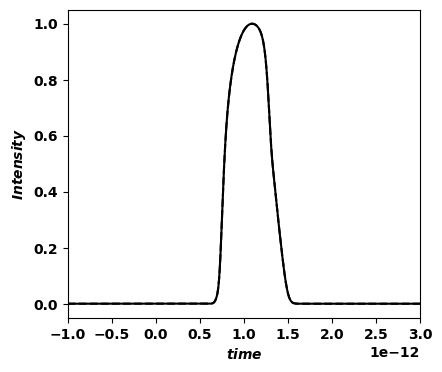

In [49]:
f = plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(TimeGrid,np.abs(y2)**2/np.amax(np.abs(y2)**2),'--k')
plt.plot(TimeGrid,np.abs(yk)**2/np.amax(np.abs(yk)**2),'k')
plt.ylabel('$Intensity$')
plt.xlabel('$time$')
#plt.plot(TimeGrid,np.abs(A2)**2/np.amax(np.abs(A2)**2))
plt.xlim(-1e-12,3e-12)


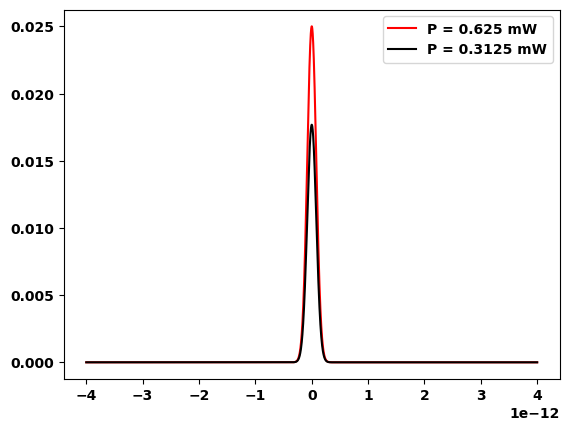

In [41]:
plt.plot(TimeGrid,A1,'r',label = 'P = 0.625 mW')
plt.plot(TimeGrid,A2,'k',label = 'P = 0.3125 mW')
plt.legend()

(-1.0, 1.0)

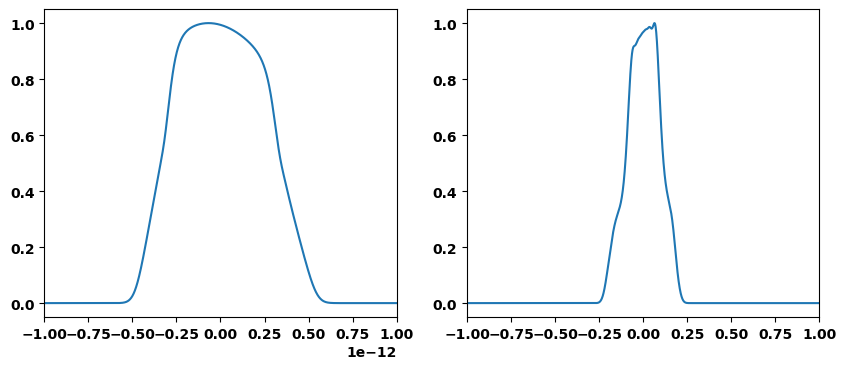

In [46]:
f = plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(TimeGrid,np.abs(y1)**2/np.amax(np.abs(y1)**2))
#plt.plot(TimeGrid,np.abs(A2)**2/np.amax(np.abs(A2)**2))
plt.xlim(-1e-12,1e-12)

plt.subplot(122)
plt.plot(V*1e-15,np.abs(fourierT(y1))**2/np.amax(np.abs((fourierT(y1))**2)))
plt.xlim(-1,1)

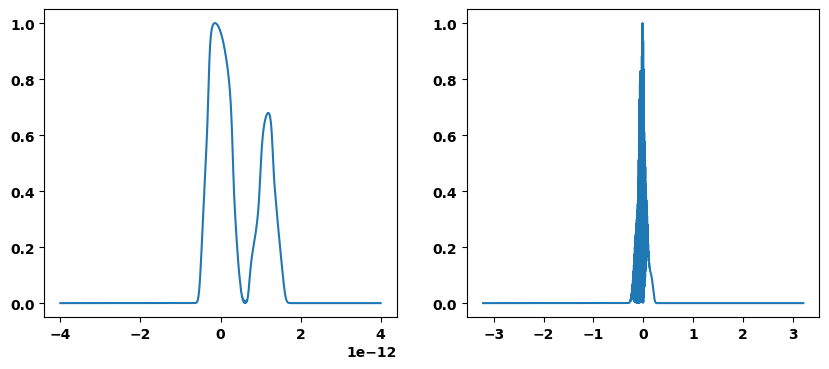

In [247]:
f = plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(TimeGrid,np.abs(y1+y2)**2/np.amax(np.abs(y1+y2)**2))
#plt.plot(TimeGrid,np.abs(A2)**2/np.amax(np.abs(A2)**2))
#plt.xlim(-1e-12,1e-12)

plt.subplot(122)
plt.plot(V*1e-15,np.abs(fourierT(y1+y2))**2/np.amax(np.abs((fourierT(y1+y2))**2)))


In [13]:
y1,y2 = fourier_split_modc(A1,A2,V,delta,S,T,C,B,gammas,betas1,betas2,length,dT,steps)

C:\Users\esteb\AppData\Local\Temp\ipykernel_61992\1516469896.py:73: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.array(I1new))*np.exp(1j*np.array(phi1new))


In [21]:
def fourier_splitC(A01,A02,gamma,beta2,beta3,WL,lenght,k):

    c = 299792458
   
    dz=0.001

    V=np.sort(np.pi*c/(WL))  #Frequencies.

    A1=fourierI(A01)*k

    A2=fourierI(A02)*k

    UD1=np.exp(dz*0.5*(1j*V**2*0.5*beta2-1j*beta3/6*V**3),dtype=complex)

    UD2=np.exp(dz*0.5*(1j*V**2*0.5*beta2-1j*beta3/6*V**3),dtype=complex)
    
    zz=0

    while zz<=lenght:

        A1a=fourierI(UD1*fourierT(A1))

        A2a=fourierI(UD1*fourierT(A2))

        N1=1j*gamma*(np.abs(A1a)**2+2*np.abs(A2a)**2)

        A1aa=np.exp(dz*N1)*A1a

        N2=1j*gamma*(np.abs(A2a)**2+2*np.abs(A1aa)**2)

        A2aa=np.exp(dz*N2)*A2a

        A1=fourierI(UD1*fourierT(A1aa))

        A2=fourierI(UD2*fourierT(A2aa))

        zz+=dz
        
    return fourierT(A1),fourierT(A2)


# Experimento.

In [30]:
def fourier_splitC(A01,A02,V,gamma,beta2,beta3,lenght,steps):

    c = 299792458

    A1 = A02

    A2 = A01

    dz = lenght/steps

    UD1=np.exp(dz*0.5*(1j*V**2*0.5*beta2-1j*beta3/6*V**3),dtype=complex)

    UD2=np.exp(dz*0.5*(1j*V**2*0.5*beta2-1j*beta3/6*V**3),dtype=complex)
    

    for i in range(steps):

        A1a=fourierI(UD1*fourierT(A1))

        A2a=fourierI(UD1*fourierT(A2))

        N1=1j*gamma*(np.abs(A1a)**2+2*np.abs(A2a)**2)

        A1aa=np.exp(dz*N1)*A1a

        N2=1j*(gamma+0.2)*(np.abs(A2a)**2+2*np.abs(A1aa)**2)

        A2aa=np.exp(dz*N2)*A2a

        A1=fourierI(UD1*fourierT(A1aa))

        A2=fourierI(UD2*fourierT(A2aa))

    return A1, A2


In [31]:
betas1 = [4e-5*1e-24*1e-3,0]
betas2 = [4e-5*1e-24*1e-3,0]
T = 0
gammas = [1,1.2]
B = [2,2]
C = [2,2]
wl1 = 1550e-9
c = 299792458;   
w01 = (2*np.pi*c)/wl1  #reference frequency [Hz]
wl2 = 1300e-9
w02 = (2*np.pi*c)/wl2  #reference frequency [Hz]
S = [1/w01,1/w02]        
n = 2**12    # number of grid points
TimeWindow = 4*1e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-TimeWindow,TimeWindow,dT) #  time grid
steps = 10
delta =  0.015625*1e-15
length = 64e3
t0 = 80e-15       # duration of input [s]
power1 = 0.625e-3        #peak power of input [W]
t01 = 80e-15
A1 = np.sqrt(power1)*np.exp(-TimeGrid**2/(2*t01**2)) 
power2 = 0.3125e-3      #peak power of input [W]
t02 = 80e-15
A2 = np.sqrt(power2)*np.exp(-TimeGrid**2/(2*t02**2))
V = np.arange(-n,n,1)*np.pi/(n*dT)

In [33]:
y1,y2 = fourier_splitC(A1,A2,V,gammas[0],betas1[0],betas1[1],length,steps)

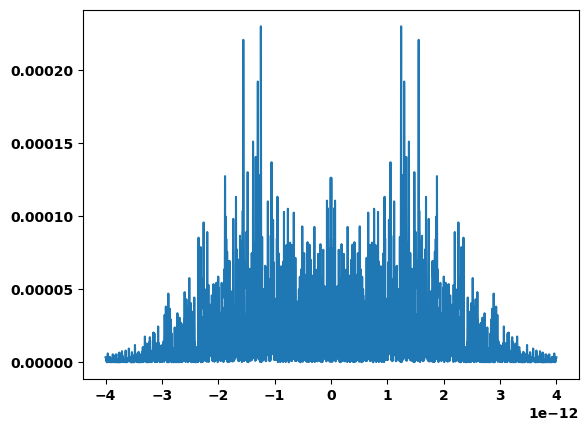

In [34]:
plt.plot(TimeGrid,np.abs(y1+y2)**2)

C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Time /s')

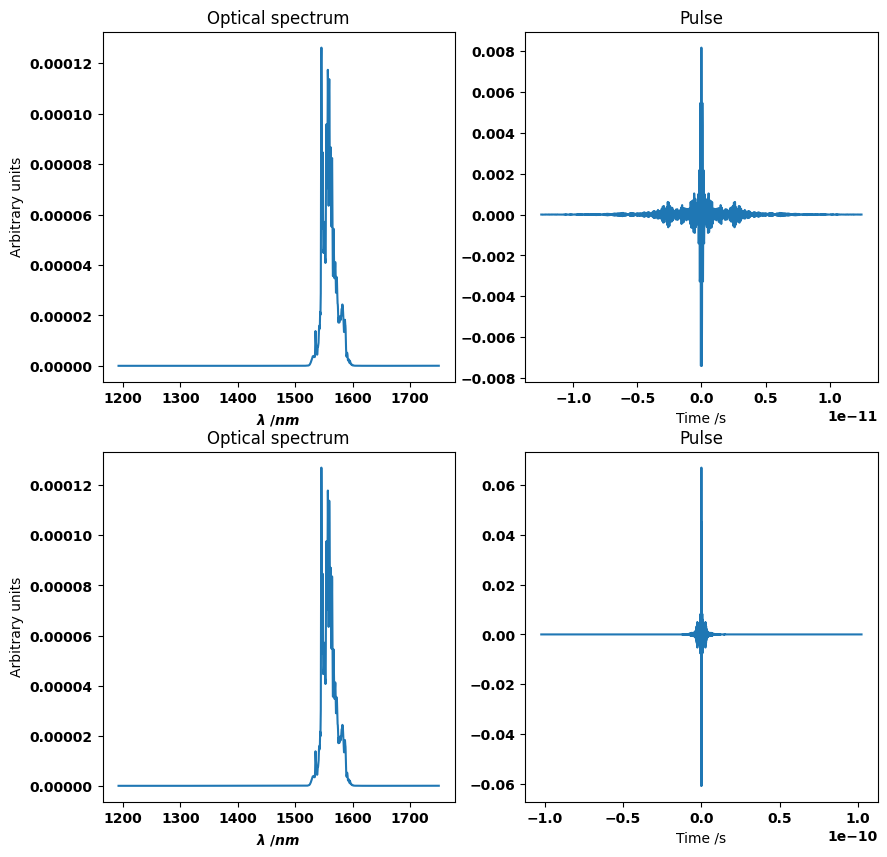

In [10]:
paths_amps=[]

for i in range(0,38):
    for j in range(0,50):
        paths_amps.append('MUESTRA_'+str(0)+'_'+str(i)+'_'+str(j)+'.csv')

del paths_amps[0]; del paths_amps[0]

s=np.random.choice(paths_amps)
df = pd.read_csv(path+'/Pulsos_amp'+"/"+s,skiprows=27)
df1 = pd.read_csv(path+'/Supercontinuo_1'+'/'+s,skiprows=27)
power=np.array(df['1749.9'][:])*1e-3 # Espectro amplificado
power_s1= np.array(df1['1749.9'][:])*1e-3 # Espectro supercontinuo.
WL_S1=np.array(df1['Stop'][:])  #Wavelenght


medium_value=np.max(power_s1)*0.01


f=plt.figure(figsize=(10,10))

plt.subplot(221)
plt.plot(WL_S1,power)
plt.title('Optical spectrum')
plt.xlabel('$\lambda$ $/nm$')
plt.ylabel('Arbitrary units')

V=np.sort(2*np.pi*c/(1e-9*WL_S1))  #Frequencies.
midV=(np.max(V)+np.min(V))/2

V=V - midV# frequency grid
n = len(WL_S1)   # number of grid points
dT = np.pi/V[-1]
TimeGrid =  np.arange(-n/2,n/2,1)*dT #  time grid

plt.subplot(222)
plt.plot(TimeGrid,(fourierI(power)))
plt.title('Pulse')
plt.xlabel('Time /s')



plt.subplot(223)

WL_S1, power = cubic(WL_S1,power,2**14)
plt.plot(WL_S1,power)
plt.title('Optical spectrum')
plt.xlabel('$\lambda$ $/nm$')
plt.ylabel('Arbitrary units')

V=np.sort(2*np.pi*c/(1e-9*WL_S1))  #Frequencies.
midV=(np.max(V)+np.min(V))/2
V=V - midV# frequency grid
n = len(WL_S1)   # number of grid points
dT = np.pi/V[-1]
TimeGrid =  np.arange(-n/2,n/2,1)*dT #  time grid

plt.subplot(224)
plt.plot(TimeGrid,(fourierI(power)))
plt.title('Pulse')
plt.xlabel('Time /s')

In [11]:
paths_amps=[]

for i in range(0,38):
    for j in range(0,50):
        paths_amps.append('MUESTRA_'+str(0)+'_'+str(i)+'_'+str(j)+'.csv')

del paths_amps[0]; del paths_amps[0]

s=np.random.choice(paths_amps)
df = pd.read_csv(path+'/Pulsos_amp'+"/"+s,skiprows=27)
df1 = pd.read_csv(path+'/Supercontinuo_1'+'/'+s,skiprows=27)
power=np.array(df['1749.9'][:])*1e-3 # Espectro amplificado
power_s1= np.array(df1['1749.9'][:])*1e-3 # Espectro supercontinuo.
WL_S1=np.array(df1['Stop'][:])  #Wavelenght

WL_S1, power = cubic(WL_S1,power,2**10)

WL_S1=np.array(df1['Stop'][:])  #Wavelenght

WL_S1, power_s1= cubic(WL_S1,power_s1,2**10)



In [12]:
def anim2(a,k,C2,C):

    pulse=np.sqrt(power)#a*np.exp(-(WL_in-WL_central)**2/(2*b**2)*(1+1j*C))
    
    pulse2=a*np.sqrt(power)*np.exp(1j*C) #cc*np.exp(-(WL_in-(WL_central+l))**2/(2*p**2))*np.exp(1j*C2)
    WaveLength=1550e-9      #reference wavelength [m]
    c = 299792458
    w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
    length = 2.0             #ibre length [m]
    D=-1.0*1e-12*1e9*1e-3 #Dispersion
    dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
    #betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
    beta2=-WaveLength**2/(2*np.pi*c)*D
    print(beta2)
    beta3=(WaveLength**2/(2*np.pi*c))**2*(2*D/WaveLength+dD)
    A = pulse
    A2= pulse2
    gamma = C2*1e-3
    sol1,sol2=fourier_splitC(A,A2,gamma,beta2,beta3,WL_S1,length,k)
    sol=np.abs(sol1)**2+np.abs(sol2)**2
    WL=WL_S1
    
    
    #plt.plot(TimeGrid,A)

    f=plt.figure(figsize=(13,5))


    plt.subplot(121)

    plt.plot(WL*1e9,power_s1/max(power_s1),label='Experimental spectrum')
    plt.plot(WL*1e9,np.abs(sol)**2/max(np.abs(sol)**2),label='Simulated spectrum')
    plt.xlabel('$\lambda/nm$',fontsize=20)
    plt.ylabel('$A.U$',fontsize=20)
    plt.legend()
    #print('Ld=',t0**2/abs(beta2))
    #print('Lnl=',1/(gamma*power))Initial

    plt.subplot(122)

    plt.plot(WL*1e9,10*np.log10(np.abs(power_s1)**2/1e-3),label='Supercontinuum spectrum')
    plt.plot(WL*1e9,10*np.log10(np.abs(sol)**2/1e-3),label='Simulated spectrum')
    plt.xlabel('$\lambda/nm$',fontsize=20)
    plt.ylabel('$dB$',fontsize=20)
    plt.ylim(-200,25)
    plt.legend()

    print(Delta_landa1(power_s1,WL))
    print(Delta_landa1(np.abs(sol)**2,WL))



In [13]:
opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        a= widgets.FloatSlider(min=0,max=1,value=1,step=0.01,**opc),  
        k=widgets.FloatSlider(min=0,max=40,value=18.980,step=0.01,**opc),
        C2=widgets.FloatSlider(min=0,max=20,value=10.8,step=0.01,**opc),
        C=widgets.FloatSlider(min=0,max=20,value=10.8,step=0.01,**opc)
        #mm
        );

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='a', max=1.0, readout_format…

In [90]:
clases_data = pd.read_csv(path+'/DATA_FRAME2_1_CLASES_GKMEANS_K_3.csv')
clases= pd.read_csv(path+'/DATA_FRAME2_2_CLASES_GKMEANS_K_3.csv')

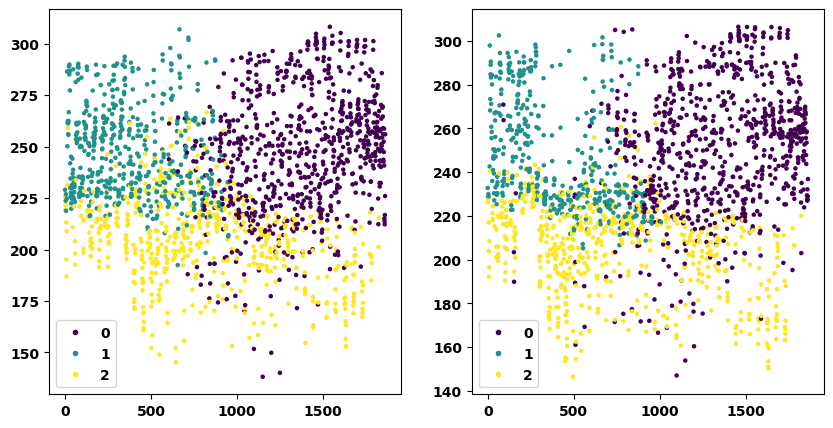

In [91]:
f=plt.figure(figsize=(10,5))

c1=np.array(clases['Clases'])
c2=np.array(clases_data['Clases'])
x=np.arange(0,len(c1),1)

plt.subplot(121)

scatter=plt.scatter(x,np.array(clases['Ancho_espectral']), c=c1, s=5,marker='o')

# Create a legend
labels = np.unique(c1)
handles = [plt.Line2D([],[],marker="o",markersize=3, ls='', color=scatter.cmap(scatter.norm(i))) for i in labels]
plt.legend(handles, labels)

# Show the plot


plt.subplot(122)
scatter=plt.scatter(x,np.array(clases_data['Ancho_espectral']), c=c2, s=5,marker='o')
labels = np.unique(c2)
handles = [plt.Line2D([],[],marker="o",markersize=3, ls='', color=scatter.cmap(scatter.norm(i))) for i in labels]
plt.legend(handles, labels)

# Show the plot
